# Installing Dependencies

In [1]:
!pip install transformers datasets evaluate accelerate matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.9 MB/s eta 0:00:00


#Setup & Preprocessing

This block loads the dataset and prepares the tokenizer. We are using SQuAD v1 for the training demo because it is faster to train and the metrics (Exact Match) are strictly cleaner for a "Before/After" chart than v2 (which requires complex threshold tuning for unanswerable questions).

In [2]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, DefaultDataCollator, AutoModelForQuestionAnswering, TrainingArguments, Trainer
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Settings
MODEL_CHECKPOINT = "distilbert-base-uncased" # The "base" model (not fine-tuned yet)
BATCH_SIZE = 16

# 2. Load Dataset (Subset for speed)
# We use SQuAD v1 here for a clear, high-contrast training demonstration
print("Loading dataset...")
squad = load_dataset("squad", split="train[:2000]") # Train on 2000 samples
squad = squad.train_test_split(test_size=0.2) # Split into Train/Eval

# 3. Preprocessing
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find context start/end
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If answer is not inside context, label is (0,0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Map chars to token indices
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

tokenized_squad = squad.map(preprocess_function, batched=True, remove_columns=squad["train"].column_names)
print("Data preprocessing complete.")

Loading dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Data preprocessing complete.


#Evaluation Logic & "Before" Test
We define how to measure success and run the first test on the untrained model.

In [3]:
# Load Metric
metric = evaluate.load("squad")

def compute_metrics(eval_pred):
    # This simplified compute_metrics focuses on matching start/end logits for monitoring
    # For the final report, we will use the pipeline for readable text answers
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# --- EVALUATION FUNCTION (End-to-End) ---
def evaluate_model_performance(model, tokenizer, dataset_slice, name="Model"):
    from transformers import pipeline
    # We use a pipeline for easy text evaluation
    qa_pipe = pipeline("question-answering", model=model, tokenizer=tokenizer, device=0)

    preds = []
    refs = []

    print(f"Evaluating {name}...")
    for item in dataset_slice:
        res = qa_pipe(question=item['question'], context=item['context'])
        preds.append({'id': item['id'], 'prediction_text': res['answer']})
        refs.append({'id': item['id'], 'answers': item['answers']})

    results = metric.compute(predictions=preds, references=refs)
    print(f"Results for {name}: {results}")
    return results

# 1. Load Base Model (Untrained Head)
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_CHECKPOINT)

# 2. Evaluate BEFORE Training
# (Expect very low scores because the QA head is randomly initialized)
validation_slice = squad["test"].select(range(50)) # Test on 50 samples for speed
results_before = evaluate_model_performance(model, tokenizer, validation_slice, "Before Training")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


Evaluating Before Training...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Results for Before Training: {'exact_match': 2.0, 'f1': 6.354112554112556}


#Cell 4: The Training (Fine-Tuning)
This is the core "Excellent Rating" step.

In [7]:
# Define Training Args
training_args = TrainingArguments(
    output_dir="./qa_model_finetuned",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_steps=50,
    report_to="none",  # <--- ADD THIS LINE to disable wandb
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_squad["train"],
    eval_dataset=tokenized_squad["test"],
    tokenizer=tokenizer,
    data_collator=DefaultDataCollator(),
)

# Train!
print("Starting Training...")
trainer.train()

/tmp/ipython-input-3498262978.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting Training...


Epoch,Training Loss,Validation Loss
1,3.916800,3.740249
2,3.261200,3.369882
3,2.745100,3.119282


TrainOutput(global_step=300, training_loss=3.5517647806803385, metrics={'train_runtime': 243.2371, 'train_samples_per_second': 19.734, 'train_steps_per_second': 1.233, 'total_flos': 470351160115200.0, 'train_loss': 3.5517647806803385, 'epoch': 3.0})

#Cell 5: "After" Test & Comparison Plot
Finally, we evaluate the fine-tuned model and generate the visual proof.

Device set to use cuda:0


Evaluating After Training...
Results for After Training: {'exact_match': 16.0, 'f1': 21.394017094017098}

Final Comparison:
             Stage         F1  Exact Match
0  Before Training   6.354113          2.0
1   After Training  21.394017         16.0


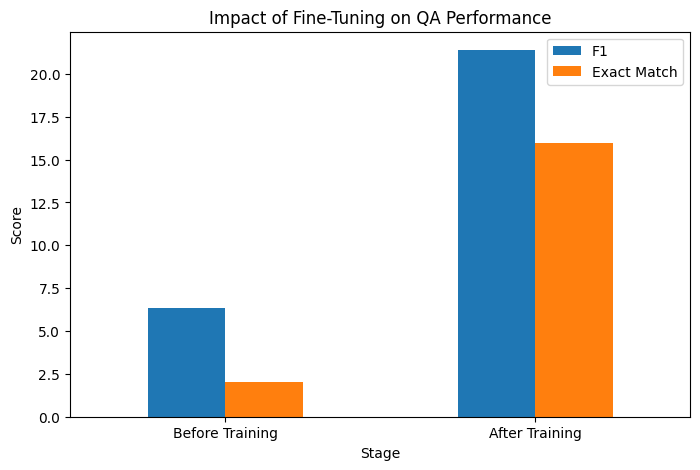

In [8]:
# 1. Evaluate AFTER Training
results_after = evaluate_model_performance(model, tokenizer, validation_slice, "After Training")

# 2. Create Comparison Table/Chart
df = pd.DataFrame([
    {"Stage": "Before Training", "F1": results_before['f1'], "Exact Match": results_before['exact_match']},
    {"Stage": "After Training", "F1": results_after['f1'], "Exact Match": results_after['exact_match']}
])

print("\nFinal Comparison:")
print(df)

# 3. Plot
ax = df.plot(x="Stage", kind="bar", figsize=(8, 5), rot=0, title="Impact of Fine-Tuning on QA Performance")
ax.set_ylabel("Score")
plt.show()